In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.ContParticleFilter import PFHestonContinuous
from src.Heston import *
from scipy.optimize import minimize
# from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.1
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] - params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 0, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

0.39


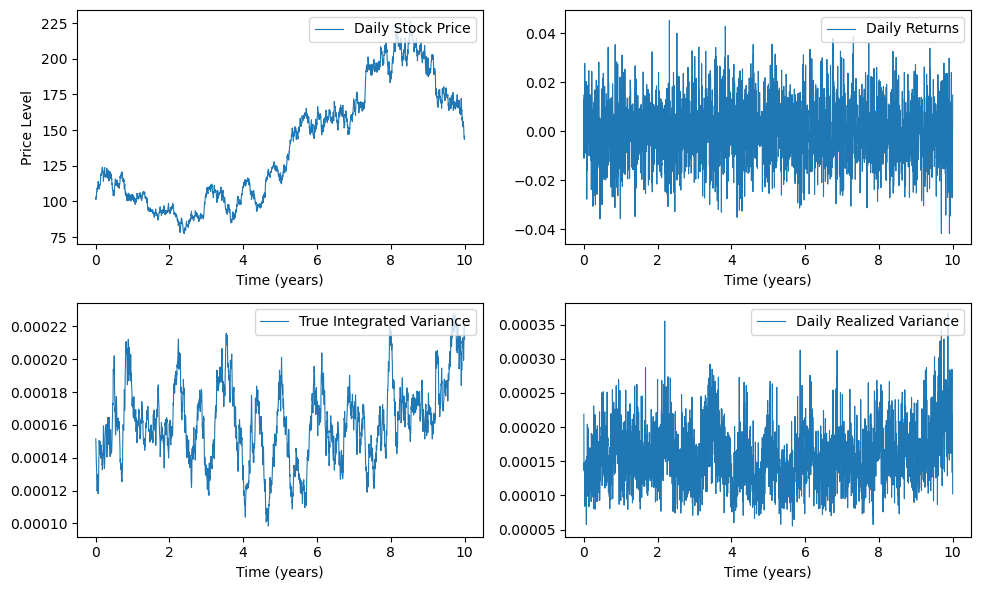

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [7]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.012367
theta: 0.000153
xi: 0.000238
mu: 0.000409
sigma: 0.000001
Negative Log-Likelihood: -14062.273218
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [1.23667643e-02 1.53317851e-04 2.37798223e-04 4.08744583e-04
 1.00000000e-06]


### Both - Corr

In [8]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])

fit_results_both = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both_corr = hkf_both_corr.filter(params_opt_both)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
V_filt_both_test_corr = hkf_both_test_corr.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.015004
theta: 0.000167
xi: 0.000402
mu: 0.000944
sigma: 0.000769
rho: -0.100000
Negative Log-Likelihood: -14054.541778
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 0.01500402  0.00016724  0.00040217  0.00094394  0.00076908 -0.10000001]


### Return

In [9]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.029450
theta: 0.000158
xi: 0.006313
mu: 0.000400
Negative Log-Likelihood: -3726.526103
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.02944992 0.00015842 0.00631345 0.00039985]


### Return - Corr

In [10]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
V_filt_returns_test_corr = hkf_returns_test_corr.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.029463
theta: 0.000158
xi: 0.006380
mu: 0.000401
rho: 0.001238
Negative Log-Likelihood: -3726.525727
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.02946263 0.00015841 0.00638043 0.00040074 0.00123827]


### RV

In [11]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.filter(params=params_opt_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.015564
theta: 0.000151
xi: 0.000332
sigma: 0.002969
Negative Log-Likelihood: -11029.375715
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.01556386 0.00015062 0.00033226 0.00296907]


### PF

In [22]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.2, 0.2),    # mu
    (1, 2),        # kappa
    (0.02, 0.1),    # theta
    (0.05, 0.1),    # xi
    (-1, 0),        # rho
    V0/252              # v0
]

V_pf_train, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
V_pf_train_daily = V_pf_train / 252

resampling since: 85.90479787001922
resampling since: 183.9191780565482
resampling since: 3108.37684014978
resampling since: 1877.213846171411
resampling since: 407.311199066768
resampling since: 499.29684895129077
resampling since: 2955.4482032175574
resampling since: 1666.457549717609
resampling since: 2492.9379358158994
resampling since: 1698.790009716837
resampling since: 1841.8355903019283
resampling since: 3358.3129207865277
resampling since: 2755.9629483446533
resampling since: 341.96383551281195
resampling since: 2291.623657970052
resampling since: 77.1540956953222
resampling since: 2018.5363163539778
resampling since: 3458.044740677469
resampling since: 2234.5821565503693
resampling since: 2002.8501202591503
resampling since: 2466.7378918981385
resampling since: 2117.3001883668103
resampling since: 3155.2739461629258
resampling since: 2503.926030492123
resampling since: 2803.9134364051833
resampling since: 2980.349912154626
resampling since: 3142.3778601880567
resampling since

In [25]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

param_bounds_test = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))
param_bounds_test.append(V_pf_train[-1]/252)

V_pf_test, _ = pf_heston_test.filter(param_bounds_test, predict_obs=False)
V_pf_test_daily = V_pf_test / 252

resampling since: 1285.993646643747
resampling since: 2878.776477280239
resampling since: 2625.2094268390297
resampling since: 3460.453967328404
resampling since: 2466.0032740368065
resampling since: 3400.7464282970577
resampling since: 3362.635190354036
resampling since: 2372.4910158009025
resampling since: 3205.3384892930885
resampling since: 3428.255686440287
resampling since: 3436.403883995984
resampling since: 3206.1323472183776
resampling since: 3005.9002283275477
resampling since: 3406.771993599466
resampling since: 3462.695124821406
resampling since: 2790.8901048991975
resampling since: 3447.4991174904976
resampling since: 3355.598694074426
resampling since: 2514.308279218411
resampling since: 3449.9568900095155
resampling since: 3461.289184913741
resampling since: 3105.8320123497315
resampling since: 3437.211341476684
resampling since: 3445.703329078932
resampling since: 3146.3841900013585
resampling since: 2095.3645827785044
resampling since: 3431.470037140237
resampling sinc

## Plot

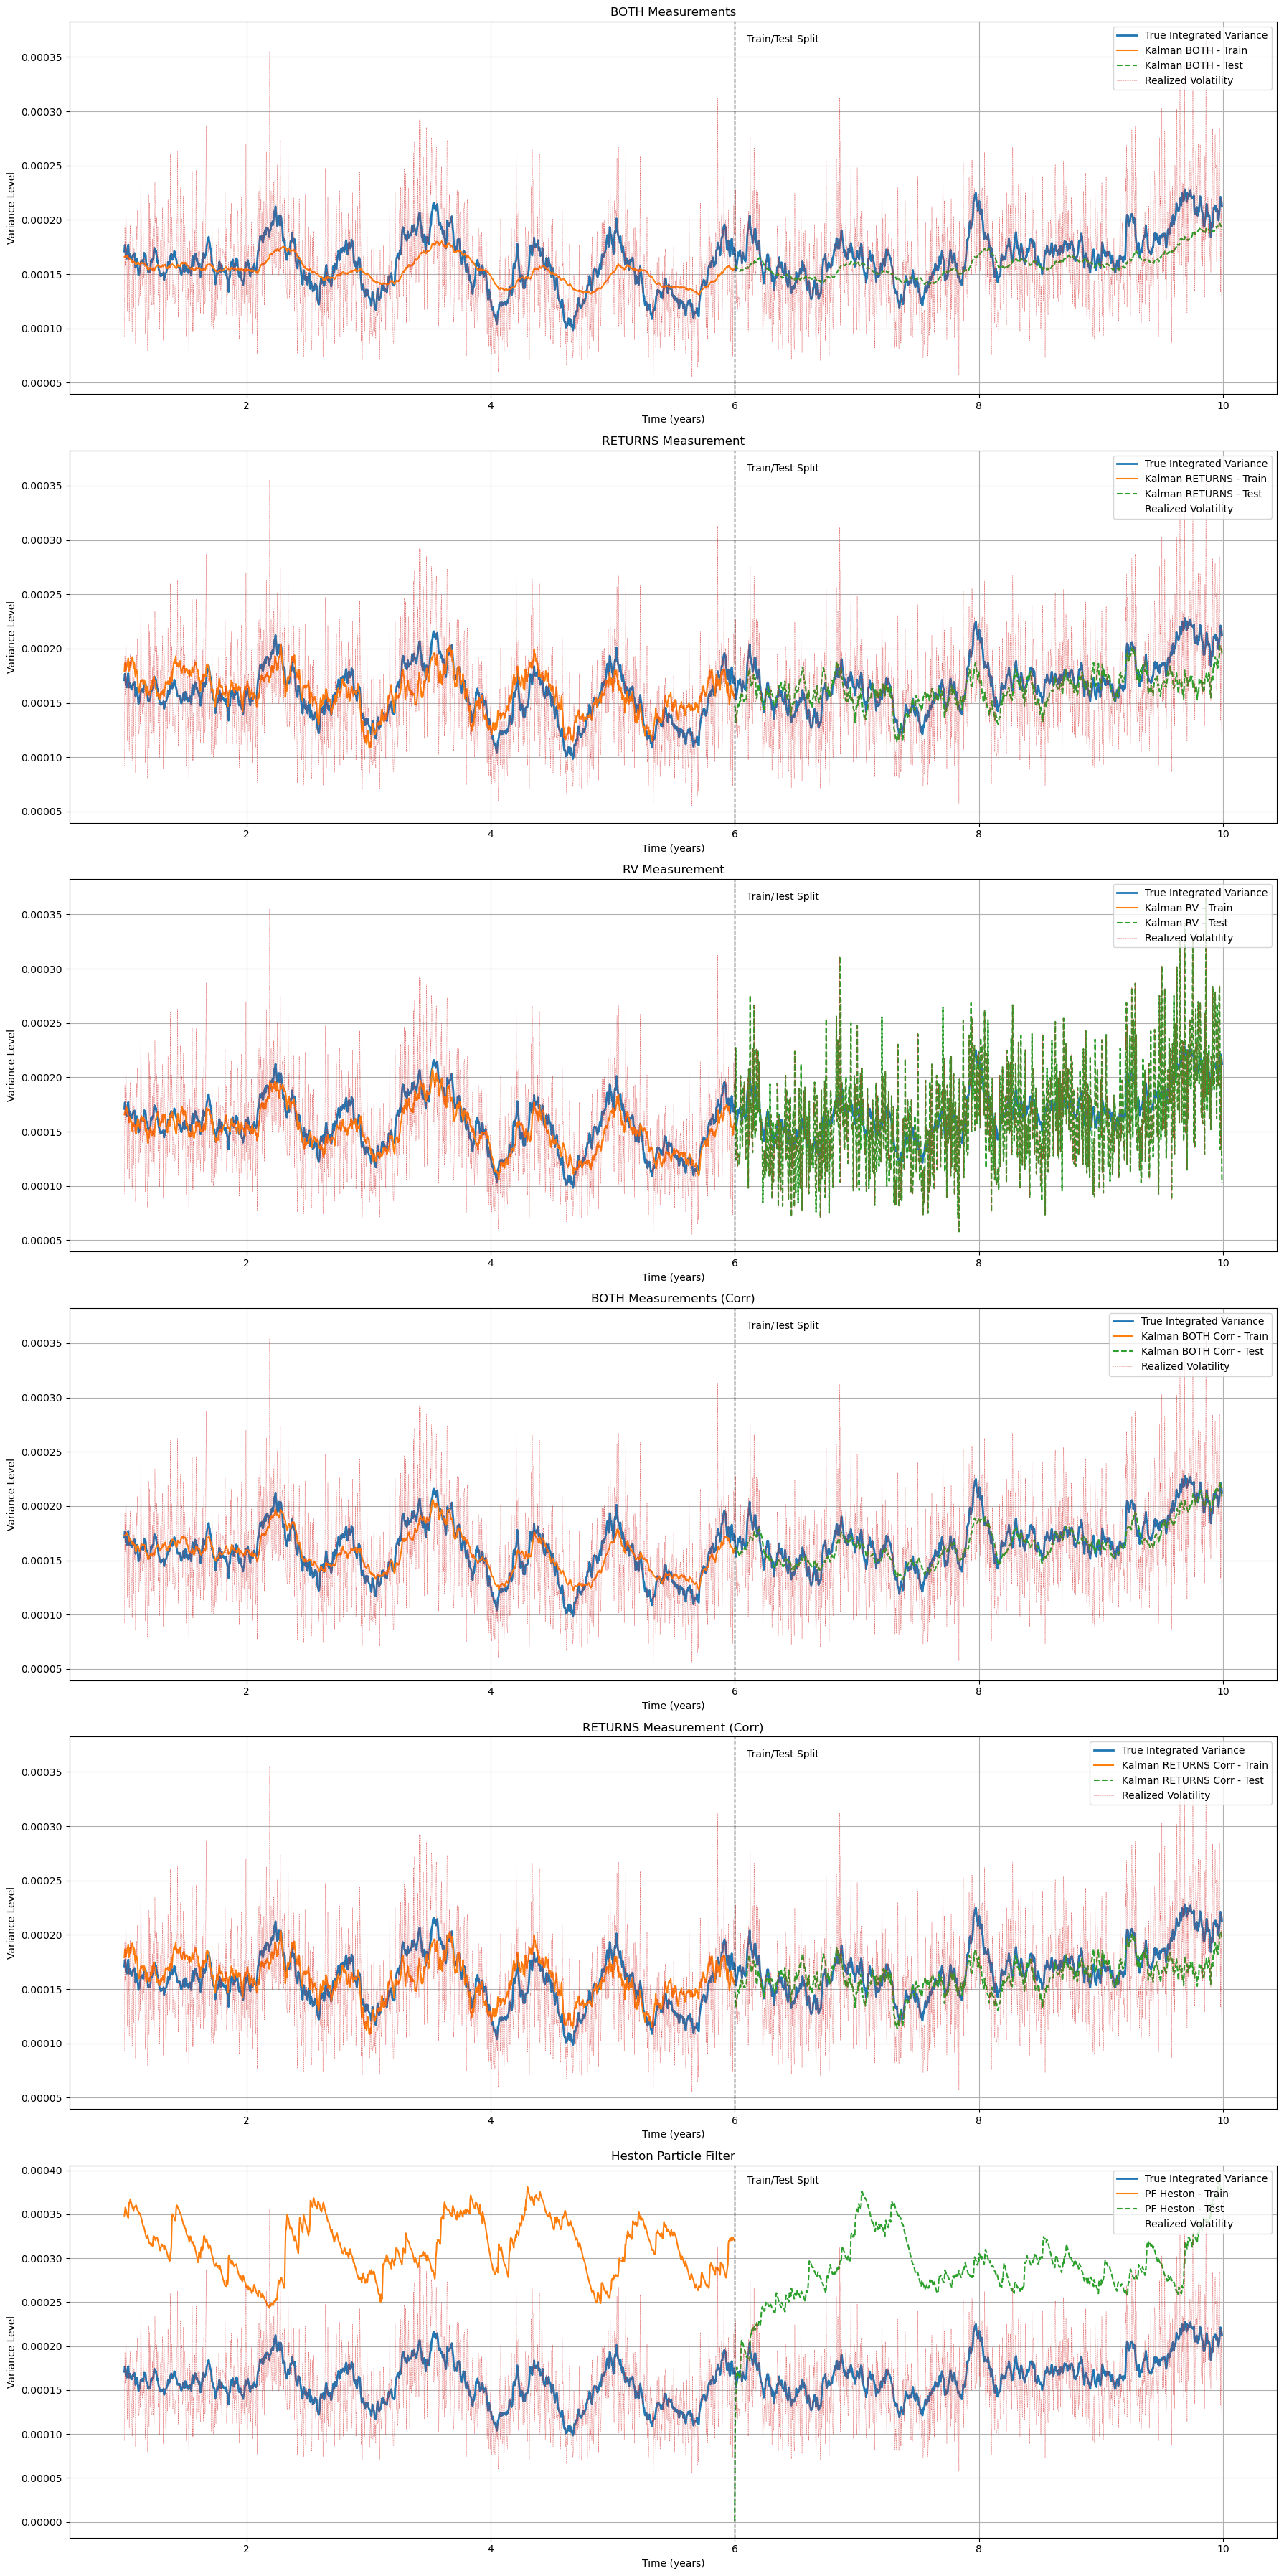

In [26]:
titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "BOTH Measurements (Corr)", "RETURNS Measurement (Corr)", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both['V_filt'], train_result_returns['V_filt'], train_result_rv['V_filt'], train_result_both_corr['V_filt'], train_result_returns_corr['V_filt'], V_pf_train_daily]
test_all = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test, V_filt_both_test_corr, V_filt_returns_test_corr, V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252,
    save_path=r"C:\Users\688228hh\Kalman-Heston-Filter\output\low_swing.png"
)

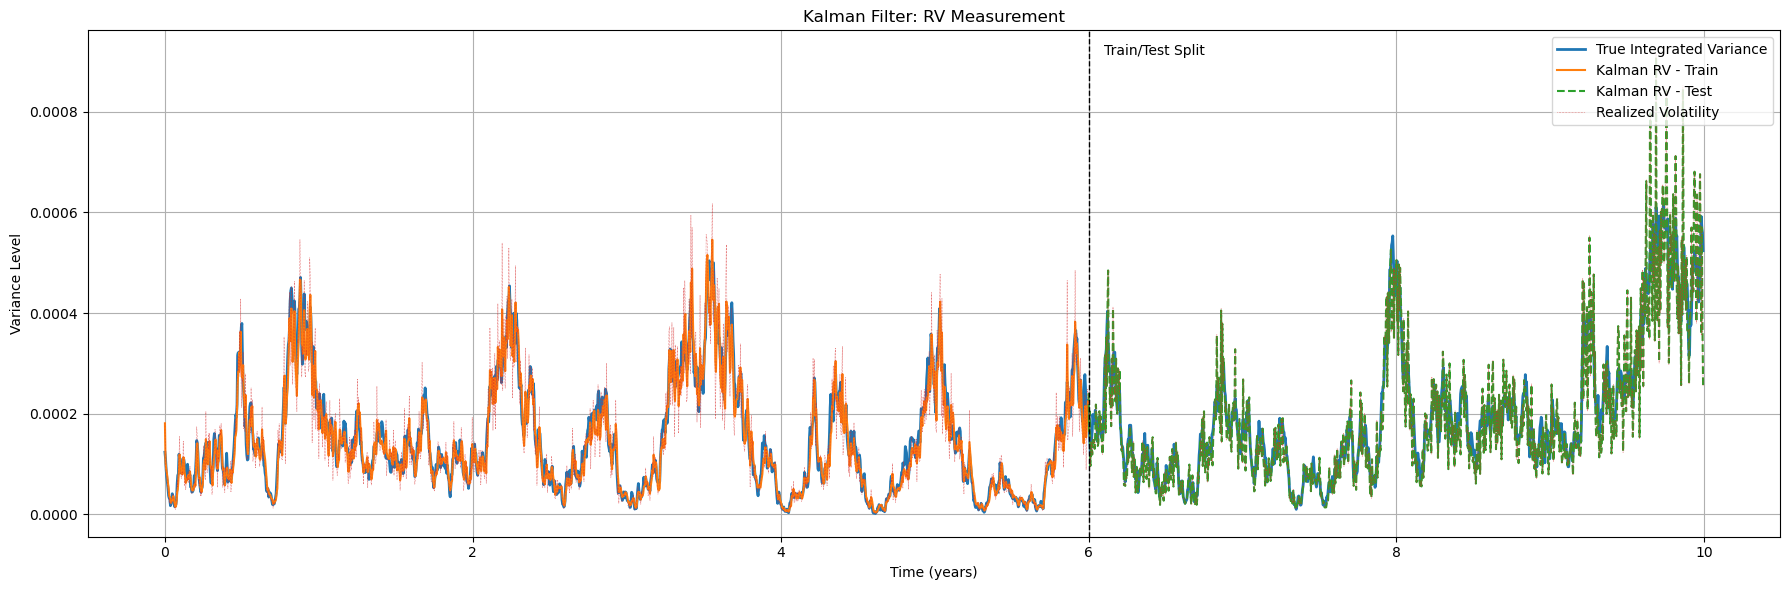

In-Sample RMSE (RV Measurement): 0.000026
Out-of-Sample RMSE (RV Measurement): 0.000055


(2.5867919148173176e-05, 5.4892072600495645e-05)

In [14]:
Utility.plot_filter_result(
    plot_index=2,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)

In [68]:
# Print RMSEs
for k, v in rmse_is_dict.items():
    print(f"In-Sample RMSE ({k}): {v:.6f}")

In-Sample RMSE (BOTH Measurements): 0.000026
In-Sample RMSE (RETURNS Measurement): 0.000043
In-Sample RMSE (RV Measurement): 0.000019


In [69]:
# Print RMSEs
for k, v in rmse_oos_dict.items():
    print(f"Out-of-Sample RMSE ({k}): {v:.6f}")

Out-of-Sample RMSE (BOTH Measurements): 0.000024
Out-of-Sample RMSE (RETURNS Measurement): 0.000107
Out-of-Sample RMSE (RV Measurement): 0.000034
